In this project, I perform a simple knn regression over the "cars details vs.csv" file to predict the selling price of a car. First, I load the necessary packages for the task.

In [1]:

library(tidyverse) # metapackage of all tidyverse packages
library(tidymodels)
library(gridExtra)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.4     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 0.1.3 ──

✔ broom        0.7.7      ✔ rsample      0.1.0 
✔ dials        0.0.9      ✔ tune         0.1.5 
✔ infer        0.5.4      ✔ workflows    0.2.2 
✔ modeldata    0.1.0      ✔ workflowsets 0.0.2 
✔ parsnip      0.1.5      ✔ yardstick    0.0.8 
✔ recipes      0.1.16     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spe

Upon loading the packages, I read the file into a variable named `cars`. I use the head() function to take a brief look at how the dataset looks like

In [2]:
cars<- read.csv("../input/vehicle-dataset-from-cardekho/Car details v3.csv")
head(cars)

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
1,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5
2,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5
3,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5
4,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5
5,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5
6,Hyundai Xcent 1.2 VTVT E Plus,2017,440000,45000,Petrol,Individual,Manual,First Owner,20.14 kmpl,1197 CC,81.86 bhp,113.75nm@ 4000rpm,5


### Data exploration

Before I start the knn regression process, I will make some visualizations to take a glimpse into how the data variables are spread and how they corellate to eachother in order to choose the best attribute to use when predicting the selling price of a car.

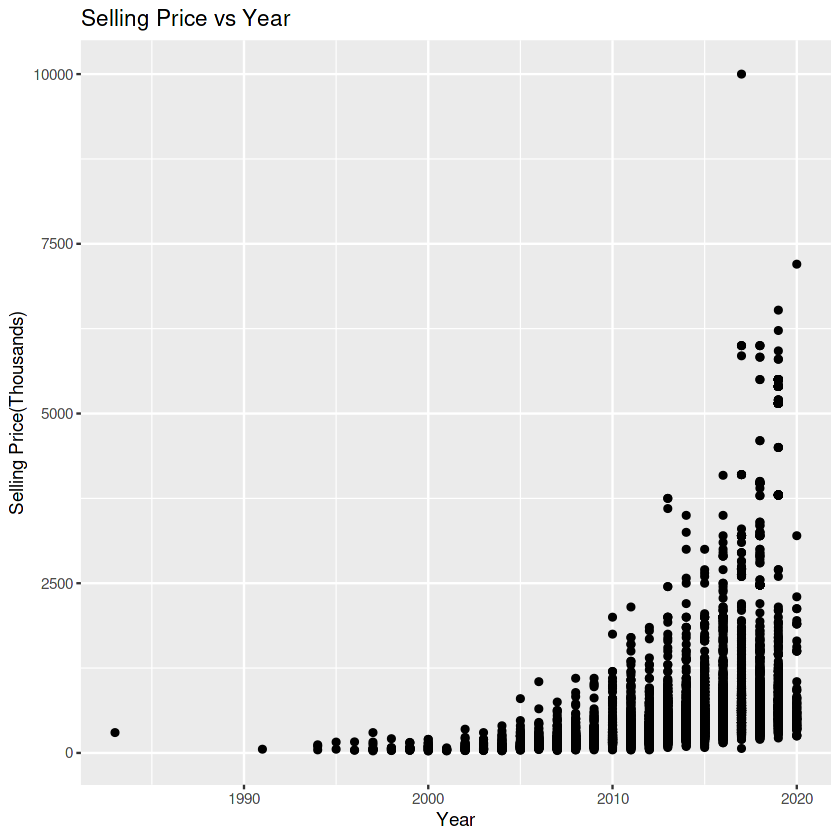

In [3]:
year_vs_price <- cars %>%
    ggplot()+
    geom_point(aes(year,(selling_price)/1000)) +
    xlab("Year")+
    ylab("Selling Price(Thousands)")+
    ggtitle("Selling Price vs Year")
year_vs_price

In the plot above, we see that, the more recently made a car is, the more likely it is to have a higher selling price

Next, I plot a graph of the kilometers driven against the selling price. Since the selling price numbers are high, I divide the selling price by 10000 to scale it down

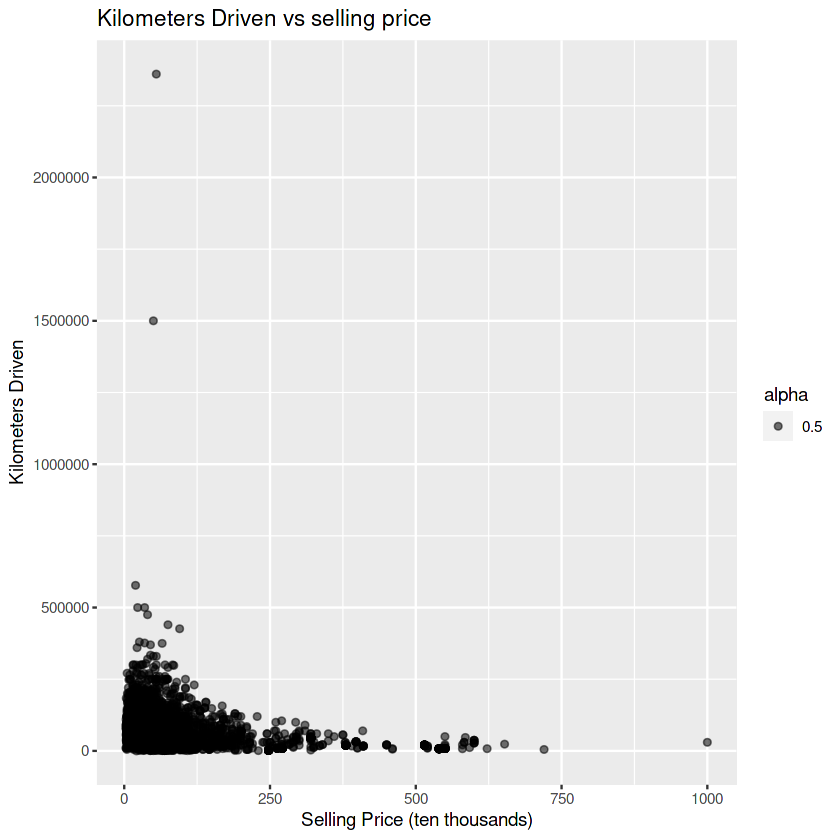

In [4]:
price_vs_km <- cars%>%
    ggplot()+
    geom_point(aes(x=selling_price/10000, y=km_driven, alpha=0.5)) +
    labs(x="Selling Price (ten thousands)", y="Kilometers Driven")+
    ggtitle("Kilometers Driven vs selling price")
price_vs_km
##here, we see that as the km driven increases, the selling price decreases

In the plot above, we see that as the kilometers driven go up, the selling price goes down. This makes sence since, the more driven a car is, the more quality it looses hence the willingness to pay for it gets lower. This inturn makes the price go down.

Next, I will make a boxplot to see the spread of different fuel types in relation to the selling prices

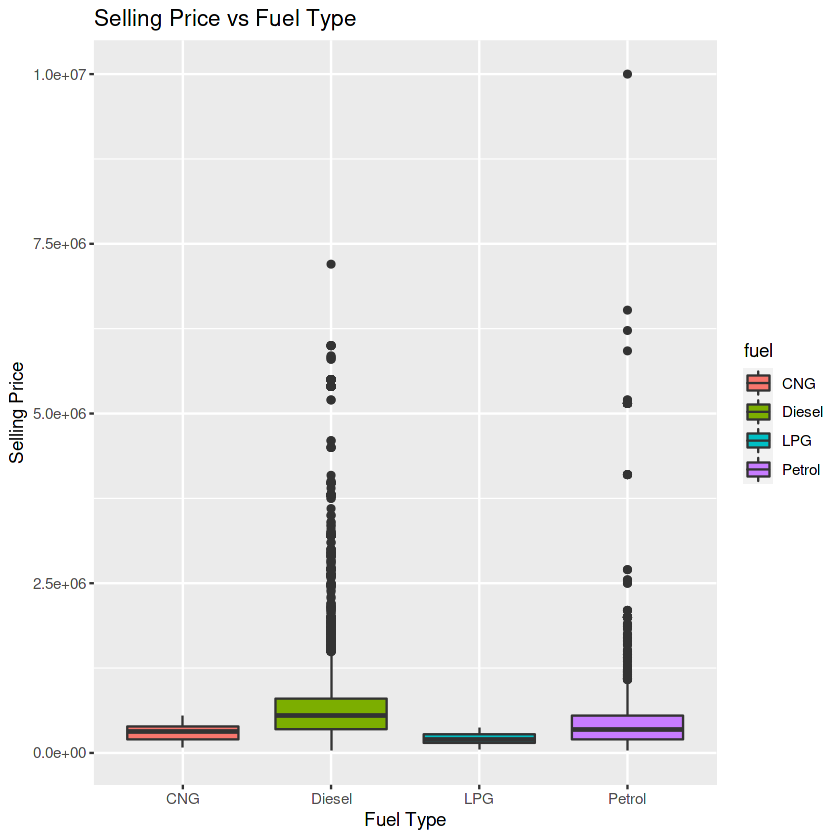

In [5]:
cars %>%
    ggplot()+
    geom_boxplot(aes(selling_price, fuel, fill=fuel))+
    coord_flip()+
    labs(x="Selling Price",y="Fuel Type")+
    ggtitle("Selling Price vs Fuel Type")

In these plots, we see that, Diesel cars are the most expensive cars on average and LPG the least. 

#### Choice of predictor: 
Having looked at these plots, I choose to predict the selling price using the year it is made since it is less clustered together as the second plot.

## knn regression model

First step in our model is to split the dataset into training set and testing set. The cell below does just that using the tidymodels package

In [6]:
set.seed(123)
cars_split <- initial_split(cars, prop=0.8, strata=selling_price)
cars_train <- training(cars_split)
cars_test <- testing(cars_split)

Next, I perform the following steps:
- make a recipe `cars_rec` that lets the model know which dataset I am using in my model and which is the predictor and which atribute we are trying to predict. I also normalize the predictor (year) to have a standard deviation of 1 and center at 0
- Make a model specification `cars_spec` that let the model know which regression model we are using
- make 5 vfolds `cars_vfold`
- put the above steps together in a workflow `cars_workflow`

In [7]:
cars_rec <- recipe(selling_price~year, 
                   data=cars_train)%>%
    step_normalize(all_predictors())
cars_spec <- nearest_neighbor(weight_func="rectangular", neighbors=tune()) %>%
    set_engine("kknn")%>%
    set_mode("regression")
cars_vfold <- vfold_cv(cars_train, v=5, strata=selling_price)

cars_workflow <- workflow()%>%
    add_recipe(cars_rec)%>%
    add_model(cars_spec)
cars_workflow

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_normalize()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


Next, I make a tibble of values `neighbors` from 300 to 600 with a step-function of +3, and then use tune_grid() and collect_metrics() functions to get the means of different number of neighbors. I do this step in order to get number of neighbors that gives me the minimal root mean square.

In [8]:
##getting_results
grid_vals <- tibble(neighbors=seq(from=300,to=600, by = 3))

cars_results <- cars_workflow%>%
    tune_grid(resamples=cars_vfold, grid=grid_vals) %>%
    collect_metrics()%>%
    filter(.metric=="rmse")
head(cars_results)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
300,rmse,standard,742750.4,5,24295.81,Preprocessor1_Model001
303,rmse,standard,742166.6,5,24182.16,Preprocessor1_Model002
306,rmse,standard,742130.4,5,23688.23,Preprocessor1_Model003
309,rmse,standard,741659.1,5,23815.65,Preprocessor1_Model004
312,rmse,standard,741014.8,5,23658.72,Preprocessor1_Model005
315,rmse,standard,740464.6,5,23697.97,Preprocessor1_Model006


From here, I make a plot of mean against neighbors inorder to visualise the number of neighbors needed for the minimal root mean square

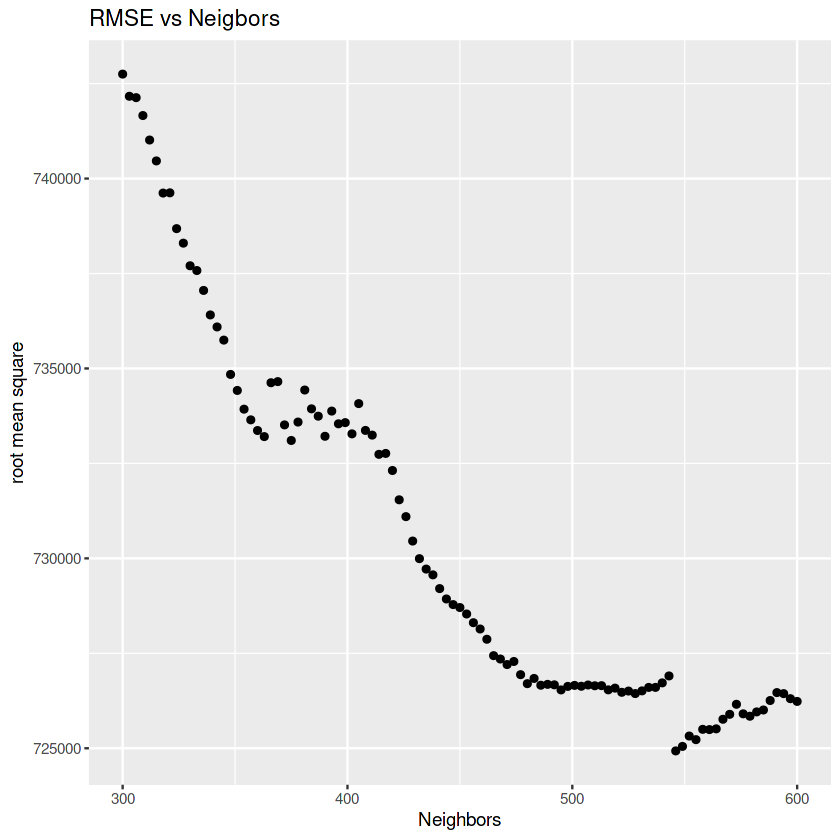

In [9]:
cars_results %>% ggplot()+
    geom_point(aes(x=neighbors, y=mean)) +
    xlab("Neighbors")+
    ylab("root mean square")+
    ggtitle("RMSE vs Neigbors")

In the plot above, we see that the neighbors needed for the minimal rmse is between 500 and 600.

In the cell below, I pull out the row with the minimum rmse


In [10]:
mean_sq <- cars_results %>%
    filter(mean==min(mean))
mean_sq

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
546,rmse,standard,724930.3,5,21733.75,Preprocessor1_Model083


I then pull the exact number of neighbors needed and store it in the `kmin` variable

In [11]:
kmin <- mean_sq %>% pull(neighbors)
kmin

[1] 546

Having  found the `kmin`, I then modify the `cars_spec` variable to contain `kmin`. I also add a `cars_fit` variable with a workflow where I add a model, recipe and fit the model into `cars_train`.

I then use the model to predict `cars_test` and collect the metrics, then store the results into `cars_summary`

In [12]:
cars_spec <- nearest_neighbor(weight_func="rectangular", neighbors=kmin) %>%
    set_engine("kknn")%>%
    set_mode("regression")
cars_fit <- workflow() %>%
    add_recipe(cars_rec) %>%
    add_model(cars_spec)%>%
    fit(data=cars_train)
cars_summary <- cars_fit %>%
    predict(cars_test) %>%
    bind_cols(cars_test) %>%
    metrics(truth=selling_price, estimate=.pred) %>%
    filter(.metric=="rmse")
cars_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,609793.3


Finally, I make a plot of the prediction I made, and make a plot to predict the price of cars from 1990 to 2020 with a step-function of +2

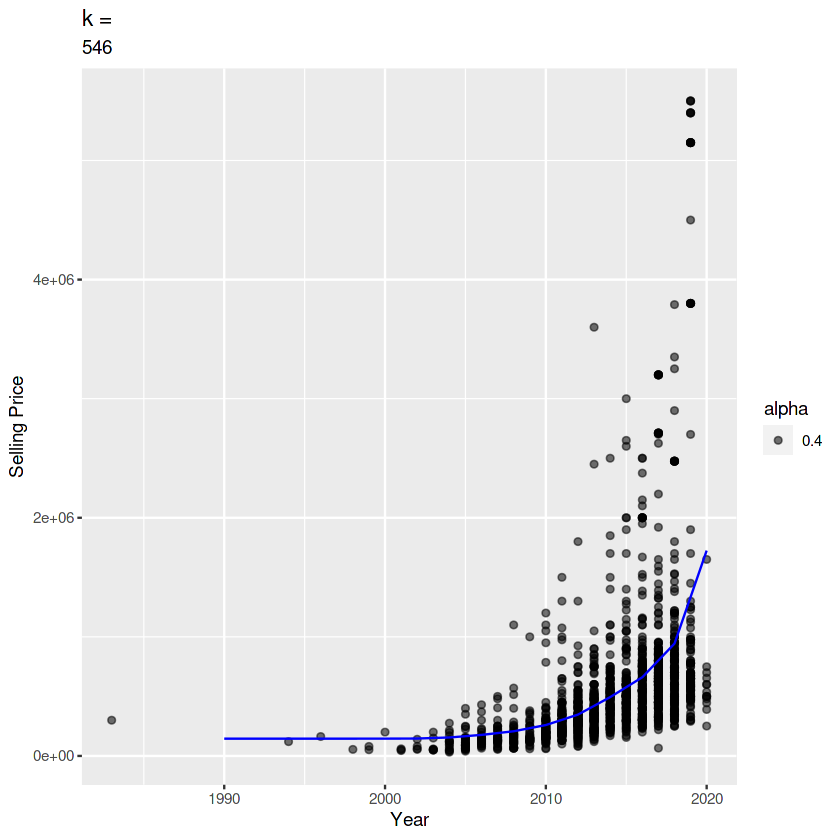

In [13]:
cars_preds <- tibble(year= seq(from=1990, to=2020, by=2))

cars_preds <- cars_fit %>%
    predict(cars_preds)%>%
    bind_cols(cars_preds)
plot<- ggplot()+
    geom_point(data=cars_test, aes(x=year, y=selling_price, alpha=0.4))+
    geom_line(data=cars_preds, aes(x=year, y=.pred), color="blue")+ 
    labs(x="Year", y="Selling Price")+
    ggtitle("k = ", kmin)
plot

In the plot above, we see that the knn-regression line is just expected as it is trending up as the years increase. 

Thank you for going through the project. Please feel free to provide thoughts on the project and let me know how I could make this prediction better.